## Домашняя работа #2.
Эта домашка про Фурье и немного про простейшие фильтры.

**Soft deadline: 02.03.2023 03:00:00 +0003 GMT**

**Hard deadline: 09.03.2023 03:00:00 +0003 GMT**

Ссылка на материалы: https://drive.google.com/drive/folders/1ZHo9MpdaOS1Qwc_F342wTByJNX0eHKmN?usp=sharing

In [2]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path("/content/drive/MyDrive/Image_analysis/Материалы")

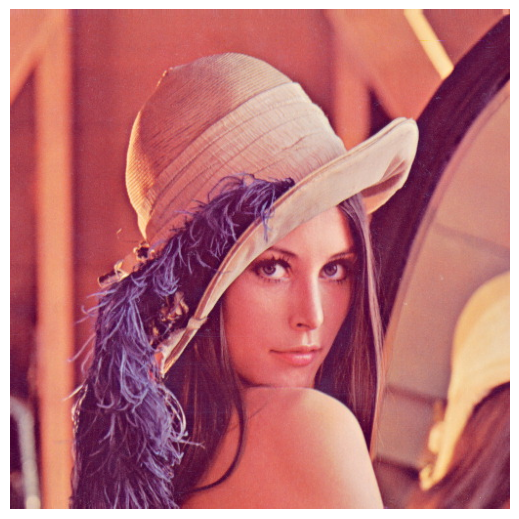

In [4]:
import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=(10, 5))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

@pyplot
def show_gray(img):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()

lena = cv2.imread(str(sources_path / "lena.jpg"))
show_bgr(lena)



**1. (5 баллов)**

Загрузите изображение $lena.jpg$ (512х512). Переведите изображение в градации серого. Произведите фильтрацию данного изображения в частотной области идеальным фильтром низких частот (фильтр, обрезающий все высокочастотные составляющие Фурье-образа, находящиеся на большем расстоянии от начала координат, чем некоторое заданное расстояние $D$), идеальным фильтром высоких частот (фильтр, обрезающий все низкокочастотные составляющие Фурье-образа, находящиеся на меньшем расстоянии от начала координат, чем некоторое заданное расстояние $D$) со следующими значениями радиуса фильтров:
1. 5
2. 15
3. 30
4. 255

Для каждого фильтра постройте состыкованное изображение из следующих: исходное изображение в градациях серого, изображение Фурье-спектра (после логарифмической коррекции для лучшей визуализации), изображение Фурье-спектра после фильтрации, изображение в пространственной области после фильтрации. На выходе должно получиться 8 изображений (4 параметра фильтров х 2 типа фильтров). Функции, которые Вам потребуются: $dft$, $mulSpectrums$, $idft$.

In [5]:
import copy

LOW_PASS = 'low'
HIGH_PASS = 'high'

def frequency_filter(dft, D, mode):
    """
    Применяет идеальный фильтр низких или высоких частот к данному изображению в частотной области.
    """
    y_center, x_center = dft.shape[0] // 2, dft.shape[1] // 2
    Y, X = np.ogrid[:dft.shape[0], :dft.shape[1]]
    dist_from_center = np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)

    if mode == LOW_PASS:
        mask = dist_from_center > D
    elif mode == HIGH_PASS:
        mask = dist_from_center < D
    else:
        raise ValueError(f"Unknown mode: {mode}")

    dft_filter = dft.copy()
    dft_filter[mask] = 0

    img = np.fft.ifft2(dft_filter)

    return dft_filter, img

def plot_results(lena_gray, spectrum_forward, dft_filter, img_filter, mode, D):
    """
    Визуализирует результаты фильтрации.
    """
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 4, 1); plt.imshow(lena_gray, cmap='gray'); plt.title('Original')
    plt.subplot(1, 4, 2); plt.imshow(spectrum_forward, cmap='gray'); plt.title('Fourier spectrum')
    plt.subplot(1, 4, 3); plt.imshow(np.log(1 + np.abs(dft_filter)), cmap='gray'); plt.title(f'{mode.capitalize()} filter, D = {D}')
    plt.subplot(1, 4, 4); plt.imshow(np.abs(img_filter), cmap='gray'); plt.title(f'{mode.capitalize()} filter, D = {D}')
    plt.show()

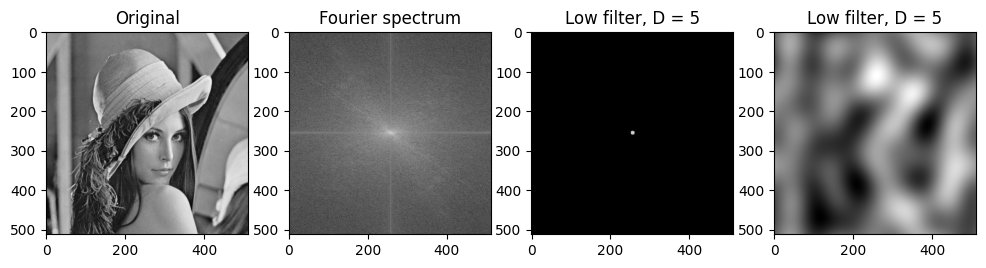

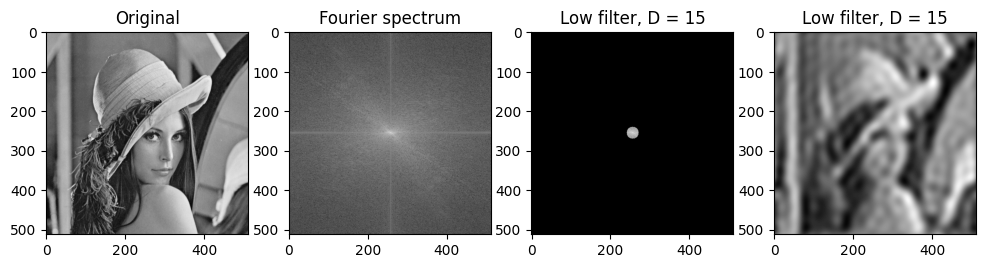

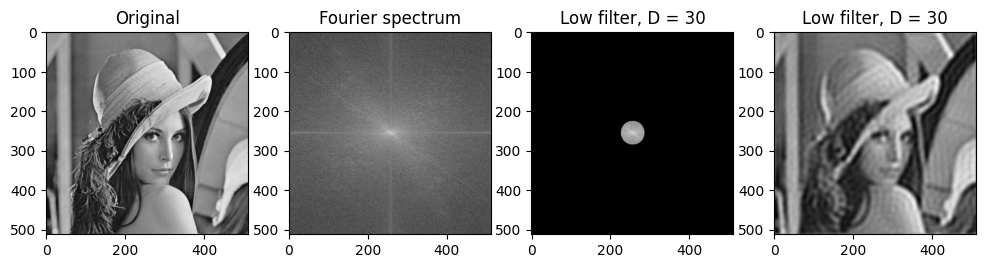

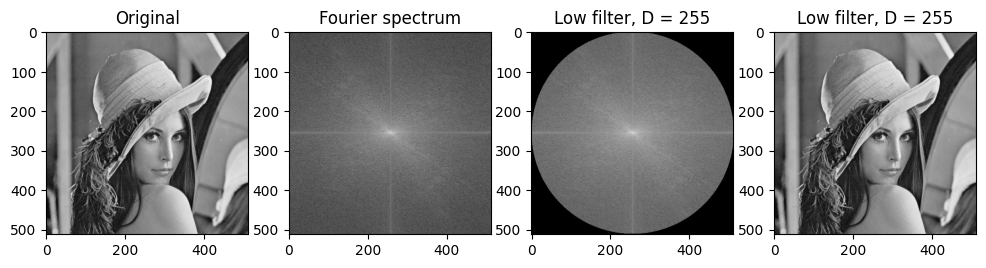

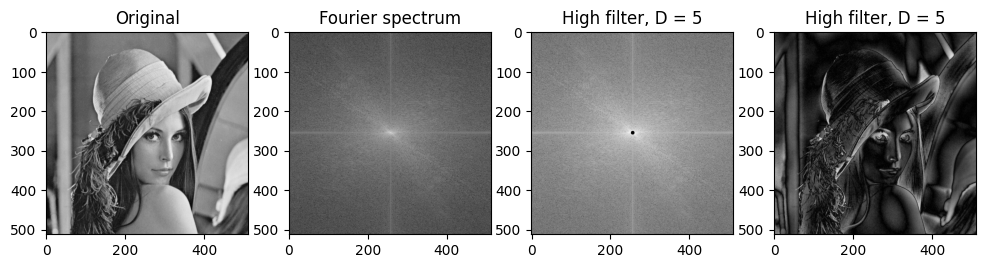

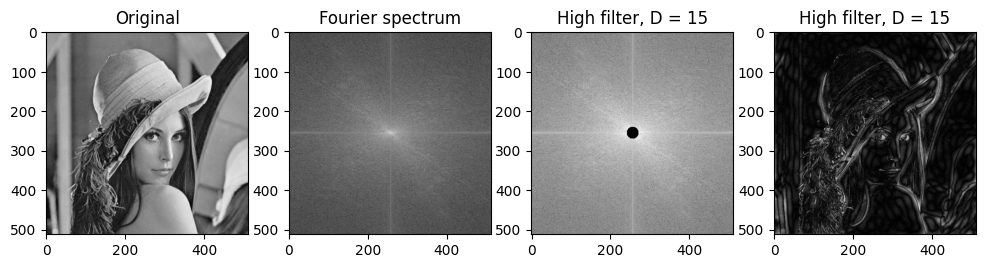

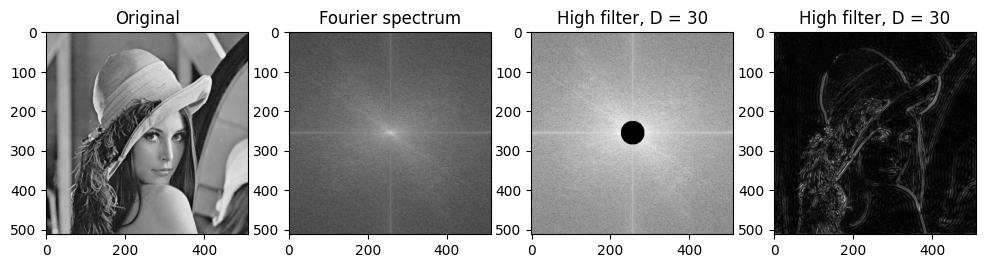

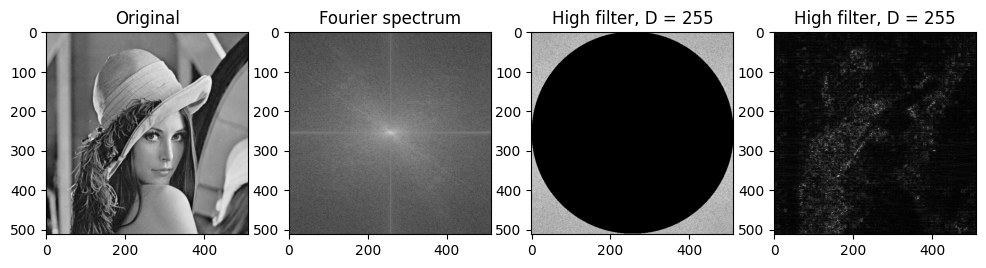

In [6]:
lena = cv2.imread(str(sources_path / "lena.jpg"))
# в градации серого
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
# Фурье преобразование + смещаем компонент нулевой частоты в центр спектра
dft = np.fft.fftshift(np.fft.fft2(lena_gray))
spectrum_forward = np.log(1 + np.abs(dft))

# Значения радиуса фильтра
D_values = [5, 15, 30, 255]
modes = [LOW_PASS, HIGH_PASS]

# Применение фильтров и отображение результатов
for mode in modes:
    for D in D_values:
        dft_filter, img_filter = frequency_filter(dft, D, mode)
        plot_results(lena_gray, spectrum_forward, dft_filter, img_filter, mode, D)

**2. (5 баллов)**

Удалите диагональные полоски с изображения $lena\_diagonal.jpg$. Вычислите среднеквадратичную ошибку (mean squared error, $MSE$, \url{http://en.wikipedia.org/wiki/Mean_squared_error}) для полученного результата и изображения $lena\_gray\_512.tif$. Задача будет засчитана при $MSE < 1500$.

3484.66450881958


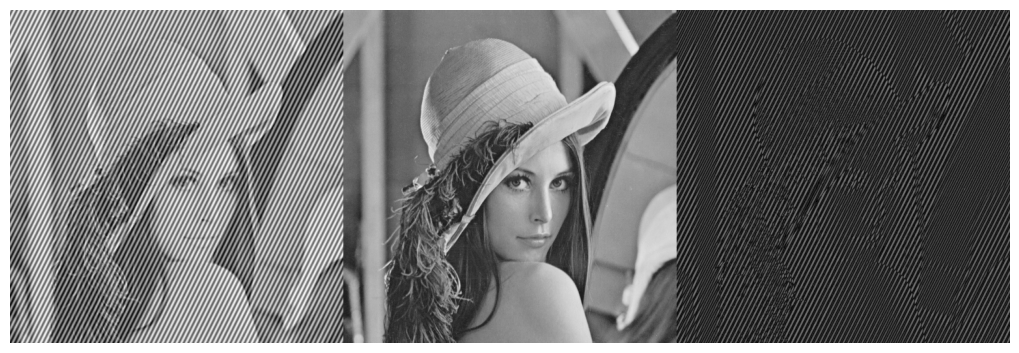

In [7]:
lena_diag = cv2.imread(str(sources_path / "lena_diagonal.jpg"), 0)
lena_gray_fix = cv2.imread(str(sources_path / "lena_gray_512.tif"), 0)

print(mse(lena_diag, lena_gray_fix))
show_gray(np.hstack([lena_diag.astype(int), lena_gray_fix.astype(int), np.abs(lena_diag.astype(int) - lena_gray_fix.astype(int))]))

In [8]:
# сделаем Фурье преобразование и смещение
fourier_transform = np.fft.fft2(lena_diag)
center_shift = np.fft.fftshift(fourier_transform)
# логарфм для лучшей визуализации
fourier_noisy = 20 * np.log(np.abs(center_shift))

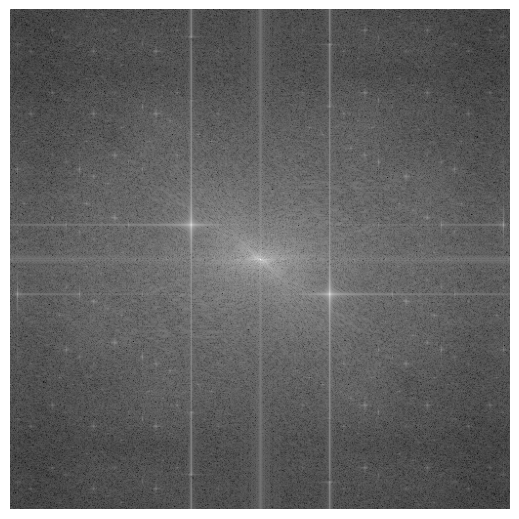

In [9]:
show_gray(fourier_noisy)

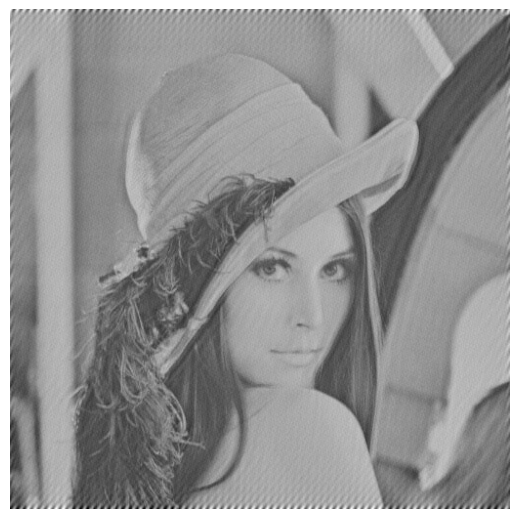

In [10]:
# просматрим на картинку спектра и вручную обнулим области с высокими значениями
center_shift[200:250, 160:210] = 0
center_shift[262:312, 302:352] = 0

# обратное преобразование и сдвиг
lena_new = np.fft.ifft2(np.fft.ifftshift(center_shift))

# итог
show_gray(lena_new.real)

In [11]:
print(mse(lena_new.real, lena_gray_fix))

903.8894157409668


**3. (10 баллов)**

Теперь предложите решение, которое бы работало для любого шума подобной природы. (синусоида некотрой частоты под некоторым углом) Смоделируйте изображение с шумом и предложите универсальный алгоритм, который решит задачу.
Тот, у кого по результатам проверки будет наименьшее значение MSE для предлженной картинки, получит призовую шоколадку (раньше мы раздавали призовые баллы, но теперь у нас концепция фиксированного максимального количества баллов)
Учтите, что помимо синусоидального шума, могут быть применены другие преобразования яркости.

---

Уточнение того, что требуется сделать:

* написать параметризованный генератор шума, которому можно задать произвольный угол, частоту полос и силу перекрытия, и получить шум с заданными параметрами

* усовершенствовать алгоритм из второй задачи, чтобы он работал на произвольных параметрах шума; тут полезно сделать интерактивный виджет, с помощью которого можно менять параметры шума и смотреть как справляется с ним алгоритм; интерактивный виджет проще всего сделать так:

    ```python
    from ipywidgets import interact

    @interact(angle=(0, 360, 1), freq=(1, 64, 1))
    def anim_general_solution(angle=45, freq=32):
        # visualization code here
    ```

* после обобщенным алгоритмом отчистить изображение из задачи 2 и посчитать MSE с чистым изображением, по этому MSE и будет конкурс за призовую шоколадку

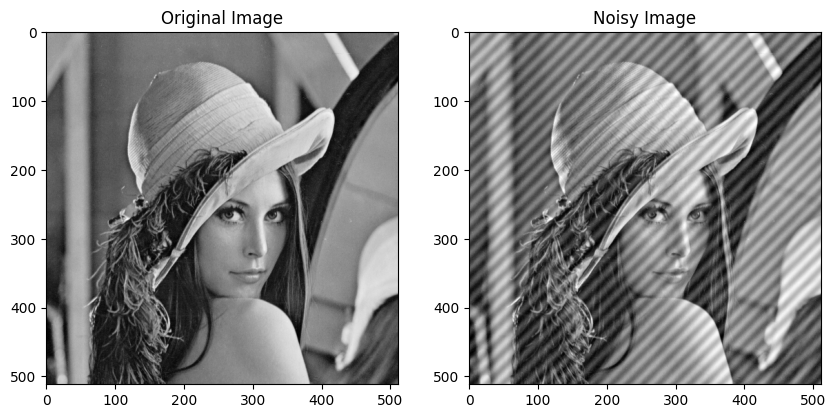

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

def add_sinusoidal_noise(image, angle, frequency, amplitude):
    noise = np.zeros_like(image, dtype=np.float32)
    rows, cols = image.shape
    rad_angle = np.deg2rad(angle)
    for i in range(rows):
        for j in range(cols):
            x = i * np.cos(rad_angle) + j * np.sin(rad_angle)
            noise[i, j] = amplitude * np.sin(2 * np.pi * frequency * x / rows)
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Пример использования
image = cv2.imread(str(sources_path / "lena_gray_512.tif"), 0)
noisy_image = add_sinusoidal_noise(image, angle=45, frequency=32, amplitude=30)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.show()


**4. (5 баллов)**

Подавите шум на изображении $lena\_color\_512\_noise.tif$. Вычислите среднеквадратичную ошибку ($MSE$) для полученного результата и изображения $lena\_color\_512.tif$. Задача будет засчитана при $MSE < 150$. Тот, у кого по результатам проверки будет наименьшее значение $MSE$ среди всех студентов для этой задачи, получит призовую шоколадку.

90.30233764648438


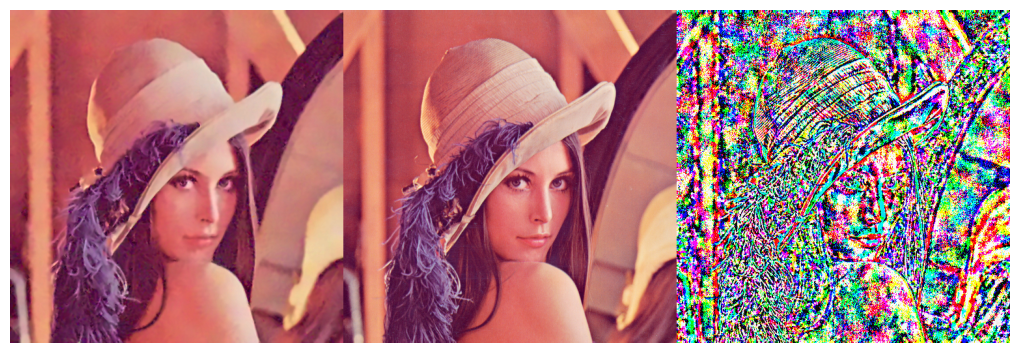

In [21]:
img_noised = cv2.imread(str(sources_path / "lena_color_512-noise.tif"))
img_colored = cv2.imread(str(sources_path / "lena_color_512.tif"))

img_filtered = cv2.medianBlur(img_noised, 3)
img_filtered = cv2.fastNlMeansDenoisingColored(img_filtered, 512, 10, 9, 7, 21)

print(mse(img_filtered, img_colored))
show_bgr(np.hstack([img_filtered, img_colored, np.abs(img_filtered - img_colored)]))

**5. (5 баллов)**

Выделите границы на изображении **cat.jpg**:

* при помощи градиента и фильтров собеля
* при помощи лапласиана
* используя алгоритм $canny$

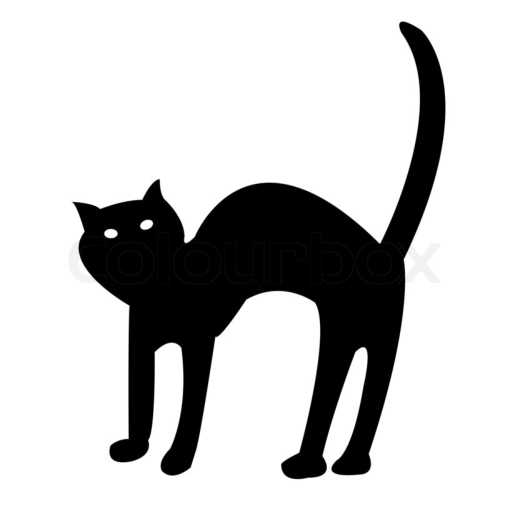

In [22]:
img = cv2.imread(str(sources_path / "cat.jpg"), 0)
show_gray(img)

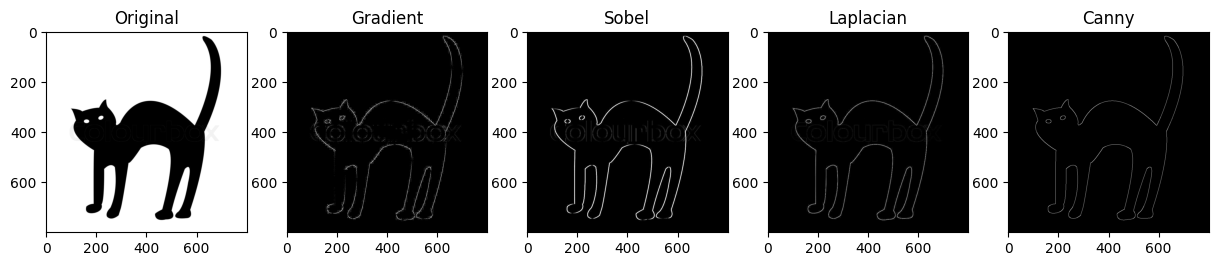

In [24]:
# 1. Градиентный фильтр
matrix_filter = np.array([[-1, 1], [1, -1]]) * 14
gradient_filter = cv2.filter2D(img, -1, matrix_filter)
gradient_filter = cv2.convertScaleAbs(gradient_filter)

# 2. Фильтры Собеля
sobelt_filter = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
sobelt_filter = cv2.convertScaleAbs(sobelt_filter)

# 3. Лапласиан
laplaciant_filter = cv2.Laplacian(img, cv2.CV_32F)
laplaciant_filter = cv2.convertScaleAbs(laplaciant_filter)

# 4. Алгоритм Канни
cannyt_filter = cv2.Canny(img, 100, 200)
cannyt_filter = cv2.convertScaleAbs(cannyt_filter)

# Визуализация результатов
plt.figure(figsize=(15, 15))
plt.subplot(151);plt.imshow(img, cmap='gray');plt.title('Original')
plt.subplot(152);plt.imshow(gradient_filter, cmap='gray');plt.title('Gradient')
plt.subplot(153);plt.imshow(sobelt_filter, cmap='gray');plt.title('Sobel')
plt.subplot(154);plt.imshow(laplaciant_filter, cmap='gray');plt.title('Laplacian')
plt.subplot(155);plt.imshow(cannyt_filter, cmap='gray');plt.title('Canny')
plt.show()